In [1]:
import argparse
import logging
import pprint
import os
import sys
from itertools import chain
from collections import Counter

import torch
import torch.utils.data
import torch.nn.functional as F
import transformers
import datasets
import wandb

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import class_attention as cat

# Prepare and train a model

In [2]:
class args:
    dataset = "../data/news-category-random-split-small"
    model = "distilbert-base-uncased"
    test_class_frac = 0.0
    dataset_frac = 1.0
    batch_size = 32
    device = "cuda:0"
    lr = 1e-4
    max_epochs = 10
    normailze_cls = False
    normalize_txt = False
    scale_attention = True
    learn_temperature = True
    use_n_projection_layers = None
    share_txt_cls_network_params = False


In [3]:
(
    train_dataloader,
    test_dataloader,
    all_classes_str,
    test_classes_str,
) = cat.training_utils.prepare_dataloaders(
    dataset_name_or_path=args.dataset,
    model_name=args.model,
    test_class_frac=args.test_class_frac,
    dataset_frac=args.dataset_frac,
    batch_size=args.batch_size,
)


In [4]:
text_encoder = transformers.AutoModel.from_pretrained(args.model)
label_encoder = transformers.AutoModel.from_pretrained(args.model)

model = cat.ClassAttentionModel(
    text_encoder,
    label_encoder,
    **vars(args),
)
model = model.to(args.device)

In [5]:
parameters = model.get_trainable_parameters()
optimizer = torch.optim.Adam(parameters, lr=args.lr)

config = {k: v for k, v in vars(args).items() if not k.startswith("_")}

wandb.init(project="class_attention", config=config, tags=["notebook"])
wandb.watch(model, log="all")

wandb: Currently logged in as: guitaricet (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.20 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [6]:
model = cat.training_utils.train_cat_model(
    model,
    optimizer,
    train_dataloader,
    test_dataloader,
    all_classes_str,
    test_classes_str,
    args.max_epochs,
    args.device,
)

# Error analysis

In [7]:
text_tokenizer = test_dataloader.dataset.text_tokenizer
label_tokenizer = test_dataloader.dataset.label_tokenizer

_t, _c = test_dataloader.dataset[4]
text_tokenizer.decode(_t), label_tokenizer.decode(_c)

('[CLS] a simple question that will change your search for love [SEP]',
 '[CLS] healthy living [SEP]')

In [8]:
set(all_classes_str).difference(test_classes_str)

{'ARTS & CULTURE',
 'BLACK VOICES',
 'BUSINESS',
 'COMEDY',
 'CRIME',
 'CULTURE & ARTS',
 'DIVORCE',
 'ENTERTAINMENT',
 'ENVIRONMENT',
 'FIFTY',
 'FOOD & DRINK',
 'GOOD NEWS',
 'GREEN',
 'HEALTHY LIVING',
 'HOME & LIVING',
 'IMPACT',
 'LATINO VOICES',
 'MEDIA',
 'MONEY',
 'PARENTING',
 'PARENTS',
 'QUEER VOICES',
 'SCIENCE',
 'STYLE',
 'STYLE & BEAUTY',
 'TASTE',
 'TECH',
 'THE WORLDPOST',
 'WEDDINGS',
 'WEIRD NEWS',
 'WELLNESS',
 'WOMEN',
 'WORLDPOST'}

In [9]:
test_classes_str

['RELIGION',
 'ARTS',
 'EDUCATION',
 'WORLD NEWS',
 'SPORTS',
 'COLLEGE',
 'POLITICS',
 'TRAVEL']

In [10]:
news_dataset = datasets.load_from_disk("../data/news-category-semantic-split-small")
_, only_test_classes_data = cat.utils.split_classes(news_dataset["validation"], test_classes=test_classes_str)

otc_dataset = cat.CatDataset(
    only_test_classes_data["headline"],
    text_tokenizer,
    only_test_classes_data["category"],
    label_tokenizer,
)

test_classes_ids = label_tokenizer.batch_encode_plus(
    test_classes_str,
    return_tensors="pt",
    add_special_tokens=True,
    padding=True,
)["input_ids"]


all_classes_ids = label_tokenizer.batch_encode_plus(
    all_classes_str,
    return_tensors="pt",
    add_special_tokens=True,
    padding=True,
)["input_ids"]


otc_collator = cat.CatTestCollator(
    possible_labels_ids=test_classes_ids, pad_token_id=label_tokenizer.pad_token_id
)

all_collator = cat.CatTestCollator(
    possible_labels_ids=all_classes_ids, pad_token_id=label_tokenizer.pad_token_id
)

otc_dataloader = torch.utils.data.DataLoader(otc_dataset, collate_fn=otc_collator, shuffle=False, pin_memory=True)
otc_all_dataloader = torch.utils.data.DataLoader(otc_dataset, collate_fn=all_collator, shuffle=False, pin_memory=True)

In [11]:
metrics = cat.utils.evaluate_model_per_class(
    model,
    otc_dataloader,
    device=args.device,
    labels_str=test_classes_str,
    zeroshot_labels=test_classes_str,
)

metrics

2021-02-24 12:31:51 | WARNING | utils.py | No classes for the group multi_shot
2021-02-24 12:31:51 | WARNING | utils.py | No classes for the group multi_shot
2021-02-24 12:31:51 | WARNING | utils.py | No classes for the group multi_shot


{'acc': tensor(0.5208, device='cuda:0'),
 'P/RELIGION': 0.16666666574074074,
 'R/RELIGION': 0.3749999953125001,
 'F1/RELIGION': 0.23076918639054037,
 'P/ARTS': 0.1395348833964305,
 'R/ARTS': 0.8571428448979593,
 'F1/ARTS': 0.2399999749600022,
 'P/EDUCATION': 0.0,
 'R/EDUCATION': 0.0,
 'F1/EDUCATION': 0.0,
 'P/WORLD NEWS': 0.2702702695398101,
 'R/WORLD NEWS': 0.7142857091836735,
 'F1/WORLD NEWS': 0.3921568213763977,
 'P/SPORTS': 0.44999999775,
 'R/SPORTS': 0.3749999984375,
 'F1/SPORTS': 0.4090908576446341,
 'P/COLLEGE': 0.190476189569161,
 'R/COLLEGE': 0.6666666555555557,
 'F1/COLLEGE': 0.29629625953361144,
 'P/POLITICS': 0.9047619039002268,
 'R/POLITICS': 0.6050955410158627,
 'F1/POLITICS': 0.725190791110661,
 'P/TRAVEL': 0.9999999909090911,
 'R/TRAVEL': 0.23913043426275993,
 'F1/TRAVEL': 0.3859648797783958,
 'R_zero_shot': 0.4790401473332264,
 'P_zero_shot': 0.3902137376006825,
 'F1_zero_shot': 0.3349335963492803}

In [12]:
cat.utils.evaluate_model_per_class(
    model,
    otc_all_dataloader,
    device=args.device,
    labels_str=all_classes_str,
    zeroshot_labels=test_classes_str,
)

{'acc': tensor(0.0264, device='cuda:0'),
 'P/WEIRD NEWS': 0.0,
 'R/WEIRD NEWS': 0.0,
 'F1/WEIRD NEWS': 0.0,
 'P/BUSINESS': 0.0,
 'R/BUSINESS': 0.0,
 'F1/BUSINESS': 0.0,
 'P/WORLD NEWS': 0.5555555493827161,
 'R/WORLD NEWS': 0.35714285459183676,
 'F1/WORLD NEWS': 0.434782557277888,
 'P/SPORTS': 0.0,
 'R/SPORTS': 0.0,
 'F1/SPORTS': 0.0,
 'P/MONEY': 0.0,
 'R/MONEY': 0.0,
 'F1/MONEY': 0.0,
 'P/GOOD NEWS': 0.0,
 'R/GOOD NEWS': 0.0,
 'F1/GOOD NEWS': 0.0,
 'P/TECH': 0.0,
 'R/TECH': 0.0,
 'F1/TECH': 0.0,
 'P/RELIGION': 0.4999999750000013,
 'R/RELIGION': 0.12499999843750002,
 'F1/RELIGION': 0.1999999640000045,
 'P/PARENTS': 0.0,
 'R/PARENTS': 0.0,
 'F1/PARENTS': 0.0,
 'P/GREEN': 0.0,
 'R/GREEN': 0.0,
 'F1/GREEN': 0.0,
 'P/FIFTY': 0.0,
 'R/FIFTY': 0.0,
 'F1/FIFTY': 0.0,
 'P/ENVIRONMENT': 0.0,
 'R/ENVIRONMENT': 0.0,
 'F1/ENVIRONMENT': 0.0,
 'P/TASTE': 0.0,
 'R/TASTE': 0.0,
 'F1/TASTE': 0.0,
 'P/LATINO VOICES': 0.0,
 'R/LATINO VOICES': 0.0,
 'F1/LATINO VOICES': 0.0,
 'P/IMPACT': 0.0,
 'R/IMPACT': 0

In [13]:
random_model = cat.ClassAttentionModel(
    transformers.AutoModel.from_config(transformers.AutoConfig.from_pretrained(args.model)),
    transformers.AutoModel.from_config(transformers.AutoConfig.from_pretrained(args.model)),
)

metrics_random = cat.utils.evaluate_model_per_class(
    random_model,
    otc_dataloader,
    device=args.device,
    labels_str=test_classes_str,
    zeroshot_labels=test_classes_str,
)

metrics_random

2021-02-24 12:31:58 | WARNING | utils.py | No classes for the group multi_shot
2021-02-24 12:31:58 | WARNING | utils.py | No classes for the group multi_shot
2021-02-24 12:31:58 | WARNING | utils.py | No classes for the group multi_shot


{'acc': tensor(0.0981, device='cuda:0'),
 'P/RELIGION': 0.058823529296424454,
 'R/RELIGION': 0.3749999953125001,
 'F1/RELIGION': 0.10169489146797421,
 'P/ARTS': 0.0,
 'R/ARTS': 0.0,
 'F1/ARTS': 0.0,
 'P/EDUCATION': 0.0,
 'R/EDUCATION': 0.0,
 'F1/EDUCATION': 0.0,
 'P/WORLD NEWS': 0.0,
 'R/WORLD NEWS': 0.0,
 'F1/WORLD NEWS': 0.0,
 'P/SPORTS': 0.10747663546379596,
 'R/SPORTS': 0.9583333293402777,
 'F1/SPORTS': 0.1932772926276409,
 'P/COLLEGE': 0.0,
 'R/COLLEGE': 0.0,
 'F1/COLLEGE': 0.0,
 'P/POLITICS': 0.0,
 'R/POLITICS': 0.0,
 'F1/POLITICS': 0.0,
 'P/TRAVEL': 0.0,
 'R/TRAVEL': 0.0,
 'F1/TRAVEL': 0.0,
 'R_zero_shot': 0.16666666558159723,
 'P_zero_shot': 0.020787520595027552,
 'F1_zero_shot': 0.03687152301195189}

In [14]:
bert_model = cat.ClassAttentionModel(
    transformers.AutoModel.from_pretrained(args.model),
    transformers.AutoModel.from_pretrained(args.model),
)

metrics_bert = cat.utils.evaluate_model_per_class(
    bert_model,
    otc_dataloader,
    device=args.device,
    labels_str=test_classes_str,
    zeroshot_labels=test_classes_str,
)

metrics_bert

2021-02-24 12:32:03 | WARNING | utils.py | No classes for the group multi_shot
2021-02-24 12:32:03 | WARNING | utils.py | No classes for the group multi_shot
2021-02-24 12:32:03 | WARNING | utils.py | No classes for the group multi_shot


{'acc': tensor(0.0528, device='cuda:0'),
 'P/RELIGION': 0.0,
 'R/RELIGION': 0.0,
 'F1/RELIGION': 0.0,
 'P/ARTS': 0.0,
 'R/ARTS': 0.0,
 'F1/ARTS': 0.0,
 'P/EDUCATION': 0.0,
 'R/EDUCATION': 0.0,
 'F1/EDUCATION': 0.0,
 'P/WORLD NEWS': 0.05283018865930936,
 'R/WORLD NEWS': 0.9999999928571429,
 'F1/WORLD NEWS': 0.10035841333487577,
 'P/SPORTS': 0.0,
 'R/SPORTS': 0.0,
 'F1/SPORTS': 0.0,
 'P/COLLEGE': 0.0,
 'R/COLLEGE': 0.0,
 'F1/COLLEGE': 0.0,
 'P/POLITICS': 0.0,
 'R/POLITICS': 0.0,
 'F1/POLITICS': 0.0,
 'P/TRAVEL': 0.0,
 'R/TRAVEL': 0.0,
 'F1/TRAVEL': 0.0,
 'R_zero_shot': 0.12499999910714286,
 'P_zero_shot': 0.00660377358241367,
 'F1_zero_shot': 0.012544801666859472}

In [15]:
class_counts = Counter(otc_dataloader.dataset.labels)
class_counts

Counter({'SPORTS': 24,
         'POLITICS': 157,
         'WORLD NEWS': 14,
         'TRAVEL': 46,
         'COLLEGE': 6,
         'EDUCATION': 3,
         'RELIGION': 8,
         'ARTS': 7})

In [16]:
{k: v / len(otc_dataloader.dataset) for k, v in class_counts.most_common()}

{'POLITICS': 0.5924528301886792,
 'TRAVEL': 0.17358490566037735,
 'SPORTS': 0.09056603773584905,
 'WORLD NEWS': 0.052830188679245285,
 'RELIGION': 0.03018867924528302,
 'ARTS': 0.026415094339622643,
 'COLLEGE': 0.022641509433962263,
 'EDUCATION': 0.011320754716981131}

## Result

Parameter sharing between encoder and decoder does not improve the model

# Logit magnitudes

In [17]:
x, c, y = next(iter(test_dataloader))

In [18]:
x.shape

torch.Size([32, 25])

In [19]:
x_np = x.detach().cpu().numpy()

In [20]:
x_lt = x.split(x.size(0), dim=0)
len(x_lt), x_lt[0].shape

(1, torch.Size([32, 25]))

In [21]:
results = []  # (class, logits)

for x, c, y in tqdm(test_dataloader):
    x = x.to(args.device)
    c = c.to(args.device)

    logits = model(x, c)
    
    logits = logits.detach().cpu()
    y = y.detach().cpu()

    for logit, class_idx in zip(logits, y):
        results.append((logit, class_idx, all_classes_str[class_idx]))

In [22]:
len(results)

11603

In [23]:
results[0]

(tensor([ 0.0387, -0.2802, -0.3631, -1.0306,  0.0388,  0.1896, -0.4743, -0.0945,
         -1.8180, -2.0680, -1.6402,  1.7778, -0.3071, -0.8406, -0.7612, -0.1439,
         -0.5497, -0.3451,  0.1583,  0.8937, -0.1805,  0.6974, -1.3197, -0.2227,
         -0.5860,  1.4995,  0.6142, -0.7460,  0.5565, -0.0775, -1.8526, -0.7923,
          0.0866, 10.0416, -1.9701,  2.7305,  0.0582, -0.0728, -0.4189, -1.0358,
         -0.1335]),
 tensor(33),
 'HOME & LIVING')

In [24]:
average_abs_logit = sum(l.abs() for l, i, c in results) / len(results)
average_abs_logit

tensor([1.3333, 1.5390, 1.0819, 0.9671, 1.1699, 1.1383, 0.9462, 0.9832, 1.6989,
        1.1697, 1.1732, 1.2223, 1.2354, 1.2120, 1.1977, 1.3950, 1.3020, 1.4287,
        1.0358, 1.2390, 1.1865, 1.4378, 1.1481, 1.0775, 1.1113, 2.4342, 1.2343,
        1.6679, 1.3309, 1.7382, 0.8764, 1.6365, 1.9038, 1.5393, 1.5141, 1.3423,
        0.9925, 1.1087, 1.4658, 1.1582, 0.6891])

In [25]:
test_classes_str

['RELIGION',
 'ARTS',
 'EDUCATION',
 'WORLD NEWS',
 'SPORTS',
 'COLLEGE',
 'POLITICS',
 'TRAVEL']

<BarContainer object of 41 artists>

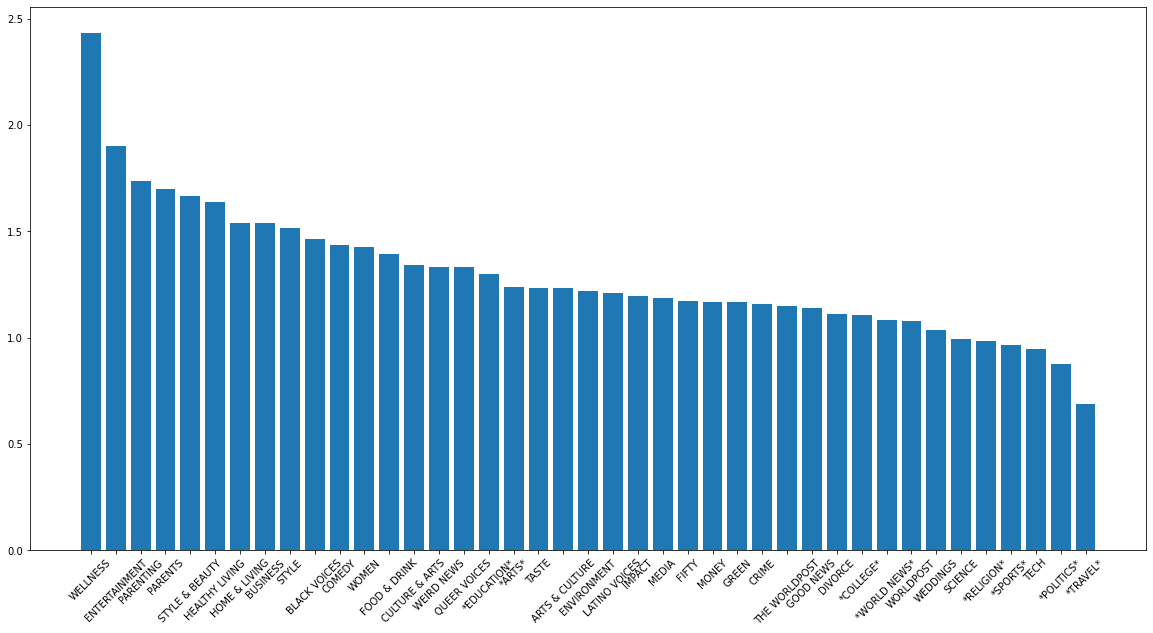

In [26]:
all_classes_str_with_marks = ["*" + c + "*" if c in test_classes_str else c for c in all_classes_str]
sorted_pairs = sorted(list(zip(all_classes_str_with_marks, average_abs_logit)), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(20, 10))
plt.xticks(rotation=45)
plt.bar(*(zip(*sorted_pairs)))

In [27]:
average_train_abs_logit = sum(l for l, c in zip(average_abs_logit, all_classes_str) if c not in test_classes_str) / (len(all_classes_str) - len(test_classes_str))
average_test_abs_logit = sum(l for l, c in zip(average_abs_logit, all_classes_str) if c in test_classes_str) / len(test_classes_str)

average_train_abs_logit, average_test_abs_logit

(tensor(1.3580), tensor(1.0309))

In [28]:
torch.exp(average_train_abs_logit), torch.exp(average_test_abs_logit)

(tensor(3.8885), tensor(2.8037))

In [31]:
F.softmax(torch.Tensor([average_train_abs_logit, average_test_abs_logit]), dim=-1)

tensor([0.5811, 0.4189])

In [34]:
1.3580 / 1.0309

1.3172955669803086

# Renormalization

This is how we call a dirty hack of artificially increasing the logits for zero-shot classes

In [57]:
from collections import defaultdict

def evaluate_model_per_class(
    model, dataloader, device, labels_str, zeroshot_labels=None, progress_bar=False, renormalization_mask=None,
):
    """
    Args:
        model: ClassAttentionModel
        dataloader: pytorch DataLoader with CatTestCollator
        labels_str: List[str], names of classes, in the same order as in the CatTestCollator.possible_labels
    """
    model = model.to(device)
    model.eval()

    if zeroshot_labels is not None and (not set(zeroshot_labels).issubset(labels_str)):
        raise ValueError("labels_str should include all labels")

    n_correct = 0
    n_total = 0
    label2n_correct = defaultdict(int)
    label2n_predicted = defaultdict(int)
    label2n_expected = defaultdict(int)

    if progress_bar:
        dataloader = tqdm(dataloader, desc="Evaluation")

    with torch.no_grad():
        for x, c, y in dataloader:
            # Note: `c` does not change in CatTestCollator
            x, c, y = x.to(device), c.to(device), y.to(device)

            logits = model(x, c)
            
            if renormalization_mask is not None:
                logits += logits * 1.32 * renormalization_mask

            _, preds = logits.max(-1)

            predicted_labels = [labels_str[i] for i in preds]
            expected_labels = [labels_str[i] for i in y]

            for label_pred, label_exp in zip(predicted_labels, expected_labels):
                label2n_predicted[label_pred] += 1
                label2n_expected[label_exp] += 1
                label2n_correct[label_pred] += int(label_pred == label_exp)

            n_correct += torch.sum(preds == y).float()
            n_total += x.shape[0]

    res = {
        "acc": n_correct / n_total,
    }

    for label in labels_str:
        label_str = label
        p = label2n_correct[label] / (label2n_predicted[label] + 1e-7)
        r = label2n_correct[label] / (label2n_expected[label] + 1e-7)

        res[f"P/{label_str}"] = p
        res[f"R/{label_str}"] = r
        res[f"F1/{label_str}"] = 2 * (p * r) / (p + r + 1e-7)

    if zeroshot_labels is not None:
        zeroshot_metrics = cat.utils._aggregate_metrics_by_class_group(res, zeroshot_labels, "zero_shot")
        multishot_labels = set(labels_str).difference(set(zeroshot_labels))
        multishot_metrics = cat.utils._aggregate_metrics_by_class_group(res, multishot_labels, "multi_shot")

        res.update(zeroshot_metrics)
        res.update(multishot_metrics)

    model.train()
    return res


In [58]:
renormalization_mask = torch.Tensor([int(c in test_classes_str) for c in all_classes_str]).to(args.device)

evaluate_model_per_class(
    model,
    test_dataloader,
    device=args.device,
    labels_str=all_classes_str,
    zeroshot_labels=test_classes_str,
    progress_bar=True,
    renormalization_mask=renormalization_mask,
)

{'acc': tensor(0.8070, device='cuda:0'),
 'P/WEIRD NEWS': 0.8883928567462532,
 'R/WEIRD NEWS': 0.9086757986718376,
 'F1/WEIRD NEWS': 0.8984198141605846,
 'P/BUSINESS': 0.9467455619434426,
 'R/BUSINESS': 0.9795918365347771,
 'F1/BUSINESS': 0.9628886158193763,
 'P/WORLD NEWS': 0.0,
 'R/WORLD NEWS': 0.0,
 'F1/WORLD NEWS': 0.0,
 'P/SPORTS': 0.0,
 'R/SPORTS': 0.0,
 'F1/SPORTS': 0.0,
 'P/MONEY': 0.8976377945687892,
 'R/MONEY': 0.9499999992083333,
 'F1/MONEY': 0.9230768723696531,
 'P/GOOD NEWS': 0.9259259250685872,
 'R/GOOD NEWS': 0.79999999936,
 'F1/GOOD NEWS': 0.8583690482418198,
 'P/TECH': 0.9593023250236614,
 'R/TECH': 0.9166666661574074,
 'F1/TECH': 0.9374999494931586,
 'P/RELIGION': 0.0,
 'R/RELIGION': 0.0,
 'F1/RELIGION': 0.0,
 'P/PARENTS': 0.9658119653992256,
 'R/PARENTS': 0.6686390530566156,
 'F1/PARENTS': 0.7902097415863886,
 'P/GREEN': 0.9425287350905007,
 'R/GREEN': 0.7735849052954789,
 'F1/GREEN': 0.8497408826867865,
 'P/FIFTY': 0.9892473107642503,
 'R/FIFTY': 0.8363636356033058,